# LSTM-Based Aftershock Prediction from Earthquake Sequences

This notebook trains Long Short-Term Memory (LSTM) networks to predict aftershock triggering from temporal sequences of earthquakes.

## Task Overview

**Input:** Temporal sequences of earthquakes
- Each sequence contains N previous earthquakes leading up to the target event
- Each earthquake has 28 engineered features

**Output:** Binary classification
- Class 0: Does not trigger aftershocks
- Class 1: Triggers aftershocks (within 7 days, 50km radius)

**Why LSTMs?**
- Capture temporal dependencies in earthquake sequences
- Model time-evolving seismic activity patterns
- Learn patterns of seismic buildup before aftershock-triggering events

## Comparison with Other Models

- **DNN**: Uses single earthquake features (no temporal context)
- **GNN**: Uses spatial/temporal graph structure
- **LSTM**: Uses temporal sequences (past earthquakes leading to current)
- **CNN**: Uses spatial grid patterns (different task: risk zones)

## Models

We'll train 4 RNN architectures:
1. **Shallow LSTM** - 1 LSTM layer (baseline)
2. **Standard LSTM** - 2 LSTM layers (main model)
3. **Bidirectional LSTM** - 2-layer BiLSTM (past + future context)
4. **GRU** - 2 GRU layers (LSTM alternative)

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')
from models.lstm import AftershockLSTM, AftershockLSTM_Shallow, AftershockLSTM_Bidirectional, AftershockGRU

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Load Data and Create Sequences

## 1. Load Data and Create Sequences

In [2]:
# Load the aftershock data (same as DNN/GNN)
print("Loading aftershock data...")
data_dict = np.load('../data/processed/model_ready/gnn_data_aftershock.npy', allow_pickle=True).item()

X = data_dict['x']  # Features: [num_earthquakes, 28]
y = data_dict['y']  # Labels: [num_earthquakes]
train_mask = data_dict['train_mask']
val_mask = data_dict['val_mask']
test_mask = data_dict['test_mask']

print(f"\nData loaded:")
print(f"  Features shape: {X.shape}")
print(f"  Labels shape: {y.shape}")
print(f"  Train: {train_mask.sum()}, Val: {val_mask.sum()}, Test: {test_mask.sum()}")

Loading aftershock data...

Data loaded:
  Features shape: (5727, 28)
  Labels shape: (5727,)
  Train: 4008, Val: 859, Test: 860


In [3]:
def create_sequences(X, y, mask, seq_length=10):
    """
    Create temporal sequences for LSTM training.

    For each earthquake at index i, create a sequence of the previous
    seq_length earthquakes (i-seq_length to i).
    """
    # Get indices for this split
    indices = np.where(mask)[0]

    # Filter out earthquakes that don't have enough history
    valid_indices = indices[indices >= seq_length]

    X_seq = []
    y_seq = []

    for idx in valid_indices:
        # Get sequence of previous earthquakes (including current)
        seq = X[idx - seq_length + 1 : idx + 1]

        # Only include if we have a full sequence
        if len(seq) == seq_length:
            X_seq.append(seq)
            y_seq.append(y[idx])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    return X_seq, y_seq

# Create sequences with lookback window of 10 earthquakes
SEQ_LENGTH = 10

print(f"\nCreating sequences with lookback window = {SEQ_LENGTH}...")
X_train_seq, y_train = create_sequences(X, y, train_mask, seq_length=SEQ_LENGTH)
X_val_seq, y_val = create_sequences(X, y, val_mask, seq_length=SEQ_LENGTH)
X_test_seq, y_test = create_sequences(X, y, test_mask, seq_length=SEQ_LENGTH)

print(f"\nSequence shapes:")
print(f"  X_train: {X_train_seq.shape} [samples, seq_length, features]")
print(f"  X_val: {X_val_seq.shape}")
print(f"  X_test: {X_test_seq.shape}")


Creating sequences with lookback window = 10...

Sequence shapes:
  X_train: (3998, 10, 28) [samples, seq_length, features]
  X_val: (859, 10, 28)
  X_test: (860, 10, 28)


## 2. Check Class Distribution

In [4]:
print(f"\nClass Distribution:")
print(f"\nTraining set:")
print(f"  Class 0 (no aftershock): {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"  Class 1 (triggers aftershock): {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")

print(f"\nValidation set:")
print(f"  Class 0: {(y_val == 0).sum()} ({(y_val == 0).mean()*100:.1f}%)")
print(f"  Class 1: {(y_val == 1).sum()} ({(y_val == 1).mean()*100:.1f}%)")

print(f"\nTest set:")
print(f"  Class 0: {(y_test == 0).sum()} ({(y_test == 0).mean()*100:.1f}%)")
print(f"  Class 1: {(y_test == 1).sum()} ({(y_test == 1).mean()*100:.1f}%)")


Class Distribution:

Training set:
  Class 0 (no aftershock): 1893 (47.3%)
  Class 1 (triggers aftershock): 2105 (52.7%)

Validation set:
  Class 0: 323 (37.6%)
  Class 1: 536 (62.4%)

Test set:
  Class 0: 413 (48.0%)
  Class 1: 447 (52.0%)


## 3. Create PyTorch Tensors and DataLoaders

In [5]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_seq)
y_train_tensor = torch.LongTensor(y_train)

X_val_tensor = torch.FloatTensor(X_val_seq)
y_val_tensor = torch.LongTensor(y_val)

X_test_tensor = torch.FloatTensor(X_test_seq)
y_test_tensor = torch.LongTensor(y_test)

print(f"\nConverted to PyTorch tensors:")
print(f"  X_train: {X_train_tensor.shape}, dtype: {X_train_tensor.dtype}")
print(f"  y_train: {y_train_tensor.shape}, dtype: {y_train_tensor.dtype}")

# Create DataLoaders
batch_size = 128

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


Converted to PyTorch tensors:
  X_train: torch.Size([3998, 10, 28]), dtype: torch.float32
  y_train: torch.Size([3998]), dtype: torch.int64

DataLoaders created:
  Train batches: 32
  Val batches: 7
  Test batches: 7


## 4. Define Training Function

In [6]:
def train_lstm_model(model, train_loader, val_loader, criterion, optimizer,
                     num_epochs=100, patience=15, model_name='LSTM'):
    model = model.to(device)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    print(f"\nTraining {model_name}...")
    print("="*70)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            optimizer.step()

            train_loss += loss.item() * batch_x.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()

        train_loss /= train_total
        train_acc = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)

                val_loss += loss.item() * batch_x.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()

        val_loss /= val_total
        val_acc = val_correct / val_total

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1:3d}/{num_epochs}] | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Early stopping
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

    # Restore best model
    model.load_state_dict(best_model_state)
    print(f"\nBest validation loss: {best_val_loss:.4f}")
    print("="*70)

    return model, history

## 5. Define Evaluation Function

In [7]:
def evaluate_model(model, test_loader, model_name='LSTM'):
    model.eval()
    model = model.to(device)

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    roc_auc = roc_auc_score(all_labels, all_probs)

    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }

    # Print results
    print(f"\n{model_name} Test Results:")
    print("="*50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print("="*50)

    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(all_labels, all_preds,
                                target_names=['No Aftershock', 'Triggers Aftershock']))

    return results

## 6. Calculate Class Weights for Imbalanced Data

In [8]:
# Calculate class weights to handle imbalance
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.FloatTensor(class_weights).to(device)

print(f"Class distribution in training set:")
print(f"  Class 0 (No aftershock): {class_counts[0]} samples")
print(f"  Class 1 (Triggers aftershock): {class_counts[1]} samples")
print(f"\nClass weights: {class_weights}")

Class distribution in training set:
  Class 0 (No aftershock): 1893 samples
  Class 1 (Triggers aftershock): 2105 samples

Class weights: tensor([0.5265, 0.4735])


## 7. Train Model 1: Shallow LSTM

In [9]:
num_features = X_train_seq.shape[2]
model_shallow = AftershockLSTM_Shallow(num_features=num_features, hidden_dim=64, dropout=0.2)
print(f"\nShallow LSTM Architecture:")
print(model_shallow)
print(f"\nTotal parameters: {sum(p.numel() for p in model_shallow.parameters()):,}")

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_shallow.parameters(), lr=0.001, weight_decay=1e-5)

model_shallow, history_shallow = train_lstm_model(
    model_shallow, train_loader, val_loader, criterion, optimizer,
    num_epochs=100, patience=15, model_name='Shallow LSTM'
)

results_shallow = evaluate_model(model_shallow, test_loader, model_name='Shallow LSTM')


Shallow LSTM Architecture:
AftershockLSTM_Shallow(
  (lstm): LSTM(28, 64, batch_first=True)
  (bn_lstm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

Total parameters: 26,338

Training Shallow LSTM...
Epoch [  1/100] | Train Loss: 0.5383 | Train Acc: 0.7279 | Val Loss: 0.3566 | Val Acc: 0.8277
Epoch [ 10/100] | Train Loss: 0.3719 | Train Acc: 0.8299 | Val Loss: 0.3614 | Val Acc: 0.8335

Early stopping at epoch 17

Best validation loss: 0.3400

Shallow LSTM Test Results:
Accuracy:  0.7163
Precision: 0.7859
Recall:    0.6242
F1 Score:  0.6958
ROC-AUC:   0.7801

Classification Report:
                     precision    recall  f1-score   support

      No Aftershock       0.67      0.82      0.73       413
Triggers Aftershock       0.79      0.62      0.70       447

           accuracy                           0.72       860
       

## 8. Train Model 2: Standard LSTM

In [10]:
model_standard = AftershockLSTM(num_features=num_features, hidden_dim=128, num_layers=2, dropout=0.3)
print(f"\nStandard LSTM Architecture:")
print(model_standard)
print(f"\nTotal parameters: {sum(p.numel() for p in model_standard.parameters()):,}")

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_standard.parameters(), lr=0.001, weight_decay=1e-5)

model_standard, history_standard = train_lstm_model(
    model_standard, train_loader, val_loader, criterion, optimizer,
    num_epochs=100, patience=15, model_name='Standard LSTM'
)

results_standard = evaluate_model(model_standard, test_loader, model_name='Standard LSTM')


Standard LSTM Architecture:
AftershockLSTM(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True, dropout=0.3)
  (bn_lstm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

Total parameters: 223,842

Training Standard LSTM...
Epoch [  1/100] | Train Loss: 0.6101 | Train Acc: 0.7071 | Val Loss: 0.3540 | Val Acc: 0.8347
Epoch [ 10/100] | Train Loss: 0.4303 | Train Acc: 0.7979 | Val Loss: 0.3414 | Val Acc: 0.8347

Early stopping at epoch 18

Best validation loss: 0.3194

Standard LSTM Test Results:
Accuracy:  0.6756
Precision: 0.9242
Recall:    0.4094
F1 Score:  0.5674
ROC-AUC:   0.7955

Classificati

## 9. Train Model 3: Bidirectional LSTM

In [11]:
model_bilstm = AftershockLSTM_Bidirectional(num_features=num_features, hidden_dim=128, num_layers=2, dropout=0.3)
print(f"\nBidirectional LSTM Architecture:")
print(model_bilstm)
print(f"\nTotal parameters: {sum(p.numel() for p in model_bilstm.parameters()):,}")

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_bilstm.parameters(), lr=0.001, weight_decay=1e-5)

model_bilstm, history_bilstm = train_lstm_model(
    model_bilstm, train_loader, val_loader, criterion, optimizer,
    num_epochs=100, patience=15, model_name='Bidirectional LSTM'
)

results_bilstm = evaluate_model(model_bilstm, test_loader, model_name='Bidirectional LSTM')


Bidirectional LSTM Architecture:
AftershockLSTM_Bidirectional(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (bn_lstm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

Total parameters: 599,234

Training Bidirectional LSTM...
Epoch [  1/100] | Train Loss: 0.5118 | Train Acc: 0.7376 | Val Loss: 0.4039 | Val Acc: 0.8300
Epoch [ 10/100] | Train Loss: 0.3833 | Train Acc: 0.8219 | Val Loss: 0.3280 | Val Acc: 0.8463

Early stopping at epoch 17

Best validation loss: 0.3214

Bidirectional LSTM Test Results:
Accuracy:  0.6977
Precision: 0.8816
Recall:    0.48

## 10. Train Model 4: GRU

In [12]:
model_gru = AftershockGRU(num_features=num_features, hidden_dim=128, num_layers=2, dropout=0.3)
print(f"\nGRU Architecture:")
print(model_gru)
print(f"\nTotal parameters: {sum(p.numel() for p in model_gru.parameters()):,}")

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_gru.parameters(), lr=0.001, weight_decay=1e-5)

model_gru, history_gru = train_lstm_model(
    model_gru, train_loader, val_loader, criterion, optimizer,
    num_epochs=100, patience=15, model_name='GRU'
)

results_gru = evaluate_model(model_gru, test_loader, model_name='GRU')


GRU Architecture:
AftershockGRU(
  (gru): GRU(28, 128, num_layers=2, batch_first=True, dropout=0.3)
  (bn_gru): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

Total parameters: 170,594

Training GRU...
Epoch [  1/100] | Train Loss: 0.5371 | Train Acc: 0.7251 | Val Loss: 0.3443 | Val Acc: 0.8289
Epoch [ 10/100] | Train Loss: 0.4016 | Train Acc: 0.8202 | Val Loss: 0.3247 | Val Acc: 0.8498
Epoch [ 20/100] | Train Loss: 0.3430 | Train Acc: 0.8449 | Val Loss: 0.3666 | Val Acc: 0.8161

Early stopping at epoch 28

Best validation loss: 0.3167

GRU Test Results:
Accuracy:  0.6802
Precision: 0.7172
Recall:

## 11. Compare All LSTM Models

In [13]:
comparison_df = pd.DataFrame([
    {
        'Model': results_shallow['model_name'],
        'Accuracy': results_shallow['accuracy'],
        'Precision': results_shallow['precision'],
        'Recall': results_shallow['recall'],
        'F1': results_shallow['f1'],
        'ROC-AUC': results_shallow['roc_auc']
    },
    {
        'Model': results_standard['model_name'],
        'Accuracy': results_standard['accuracy'],
        'Precision': results_standard['precision'],
        'Recall': results_standard['recall'],
        'F1': results_standard['f1'],
        'ROC-AUC': results_standard['roc_auc']
    },
    {
        'Model': results_bilstm['model_name'],
        'Accuracy': results_bilstm['accuracy'],
        'Precision': results_bilstm['precision'],
        'Recall': results_bilstm['recall'],
        'F1': results_bilstm['f1'],
        'ROC-AUC': results_bilstm['roc_auc']
    },
    {
        'Model': results_gru['model_name'],
        'Accuracy': results_gru['accuracy'],
        'Precision': results_gru['precision'],
        'Recall': results_gru['recall'],
        'F1': results_gru['f1'],
        'ROC-AUC': results_gru['roc_auc']
    }
])

print("\n" + "="*80)
print("MODEL COMPARISON - LSTM AFTERSHOCK PREDICTION")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

import os
os.makedirs('../results/visualizations/lstm', exist_ok=True)
comparison_df.to_csv('../results/visualizations/lstm/model_comparison.csv', index=False)
print("\nResults saved to: ../results/visualizations/lstm/model_comparison.csv")


MODEL COMPARISON - LSTM AFTERSHOCK PREDICTION
             Model  Accuracy  Precision   Recall       F1  ROC-AUC
      Shallow LSTM  0.716279   0.785915 0.624161 0.695761 0.780067
     Standard LSTM  0.675581   0.924242 0.409396 0.567442 0.795548
Bidirectional LSTM  0.697674   0.881633 0.483221 0.624277 0.752539
               GRU  0.680233   0.717172 0.635347 0.673784 0.738770

Results saved to: ../results/visualizations/lstm/model_comparison.csv


## 12. Compare with DNN and GNN Baselines

In [14]:
# Try to load DNN results if available
try:
    import pickle
    with open('../results/visualizations/dnn/test_results.pkl', 'rb') as f:
        dnn_results = pickle.load(f)

    print("\n" + "="*80)
    print("COMPARISON WITH DNN BASELINE")
    print("="*80)

    best_dnn_f1 = max(dnn_results['shallow']['f1'],
                      dnn_results['standard']['f1'],
                      dnn_results['deep']['f1'])

    best_lstm_f1 = comparison_df['F1'].max()

    print(f"\nBest DNN F1 Score: {best_dnn_f1:.4f}")
    print(f"Best LSTM F1 Score: {best_lstm_f1:.4f}")

    improvement = ((best_lstm_f1 - best_dnn_f1) / best_dnn_f1) * 100
    print(f"\nLSTM improvement over DNN: {improvement:+.2f}%")

except FileNotFoundError:
    print("\nDNN results not found. Run 05_dnn_aftershock_training.ipynb first.")

# Try to load GNN results
try:
    with open('../results/visualizations/gnn/test_results.pkl', 'rb') as f:
        gnn_results = pickle.load(f)

    print("\n" + "="*80)
    print("COMPARISON WITH GNN BASELINE")
    print("="*80)

    best_gnn_f1 = gnn_results['comparison_df']['F1'].max()
    best_lstm_f1 = comparison_df['F1'].max()

    print(f"\nBest GNN F1 Score: {best_gnn_f1:.4f}")
    print(f"Best LSTM F1 Score: {best_lstm_f1:.4f}")

    improvement = ((best_lstm_f1 - best_gnn_f1) / best_gnn_f1) * 100
    print(f"\nLSTM improvement over GNN: {improvement:+.2f}%")

except FileNotFoundError:
    print("\nGNN results not found. Run 08_gnn_aftershock_training.ipynb first.")


DNN results not found. Run 05_dnn_aftershock_training.ipynb first.

GNN results not found. Run 08_gnn_aftershock_training.ipynb first.


## 13. Visualize Training History

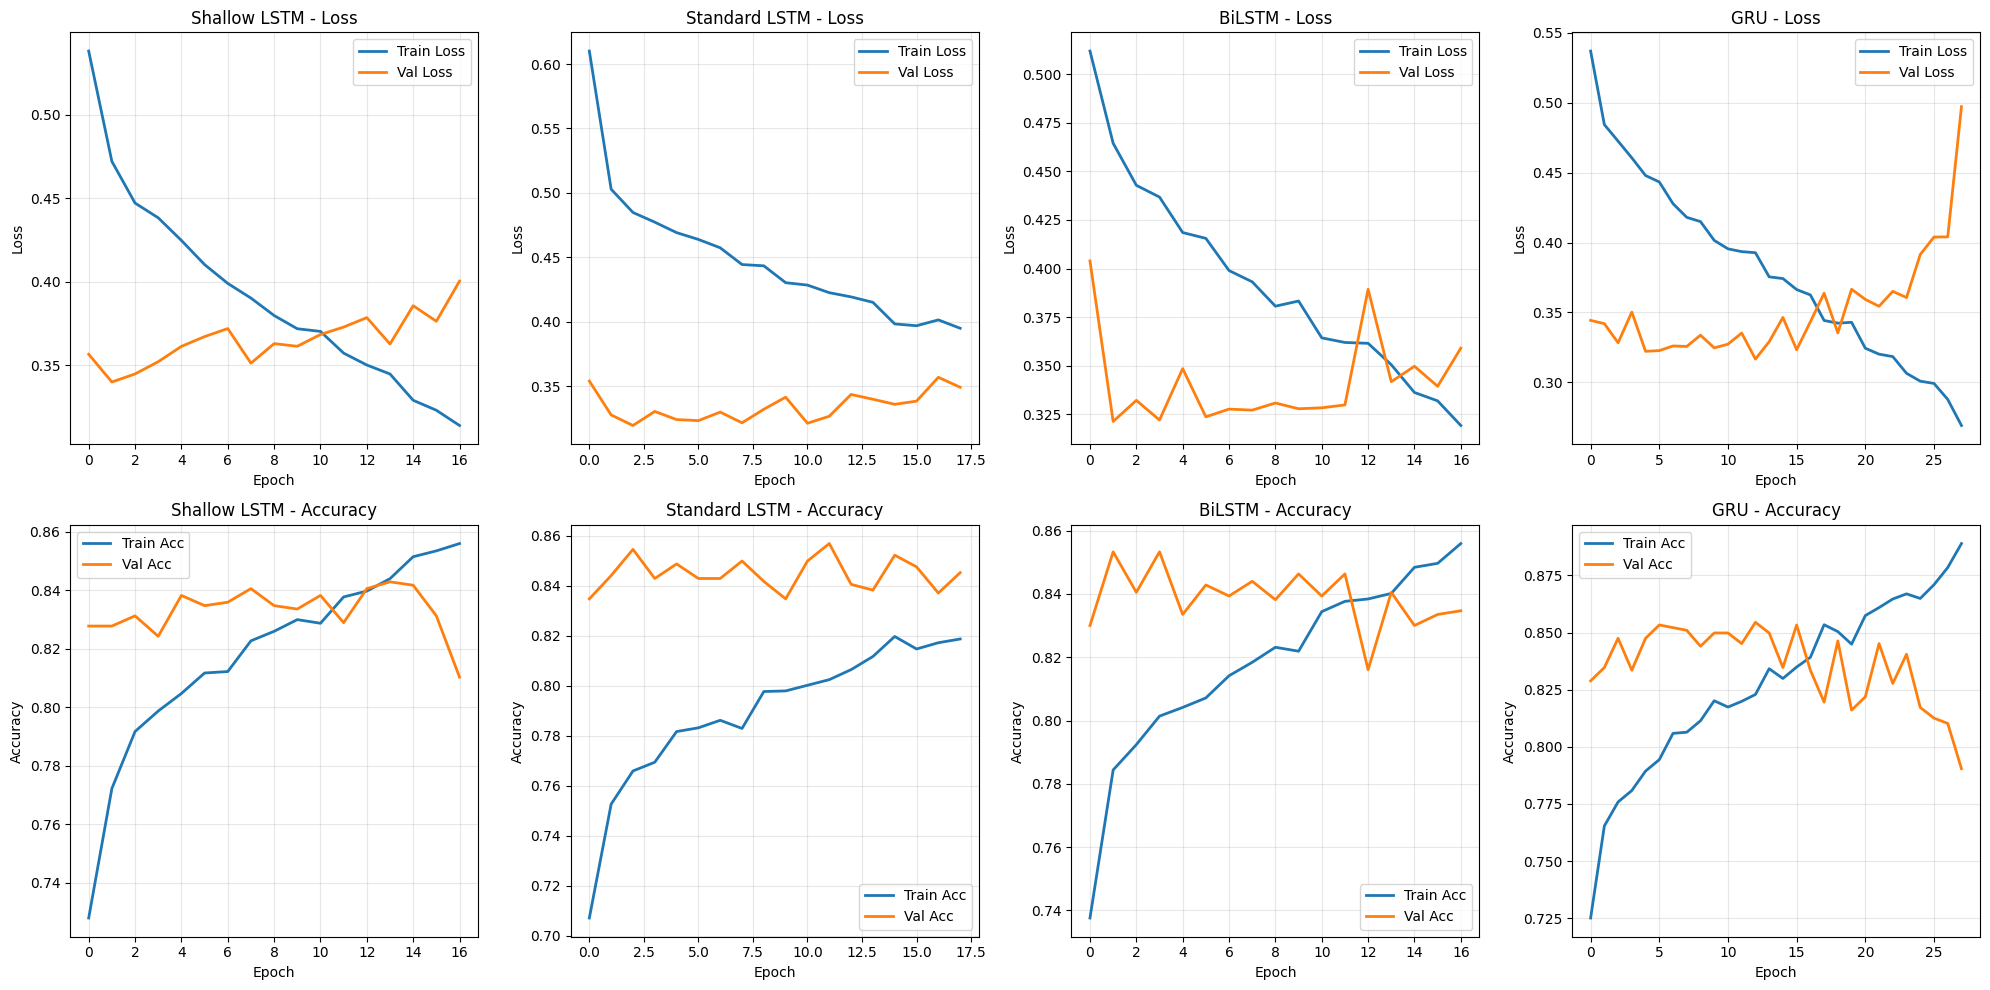

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

histories = [
    (history_shallow, 'Shallow LSTM'),
    (history_standard, 'Standard LSTM'),
    (history_bilstm, 'BiLSTM'),
    (history_gru, 'GRU')
]

for idx, (history, name) in enumerate(histories):
    # Loss plot
    axes[0, idx].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, idx].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, idx].set_xlabel('Epoch')
    axes[0, idx].set_ylabel('Loss')
    axes[0, idx].set_title(f'{name} - Loss')
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3)

    # Accuracy plot
    axes[1, idx].plot(history['train_acc'], label='Train Acc', linewidth=2)
    axes[1, idx].plot(history['val_acc'], label='Val Acc', linewidth=2)
    axes[1, idx].set_xlabel('Epoch')
    axes[1, idx].set_ylabel('Accuracy')
    axes[1, idx].set_title(f'{name} - Accuracy')
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/visualizations/lstm/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## 14. Confusion Matrices

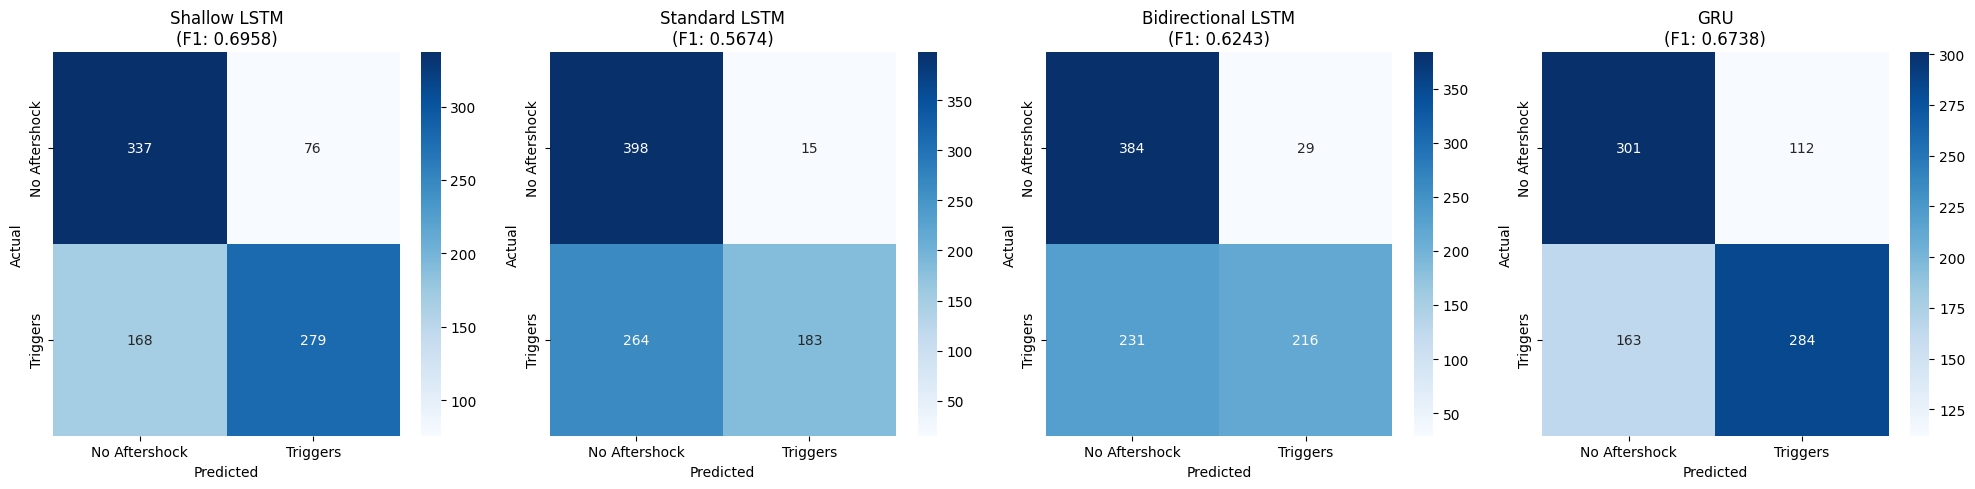

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

results_list = [results_shallow, results_standard, results_bilstm, results_gru]

for idx, results in enumerate(results_list):
    cm = confusion_matrix(results['labels'], results['predictions'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['No Aftershock', 'Triggers'],
                yticklabels=['No Aftershock', 'Triggers'])
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_title(f"{results['model_name']}\n(F1: {results['f1']:.4f})")

plt.tight_layout()
plt.savefig('../results/visualizations/lstm/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

## 15. ROC Curves

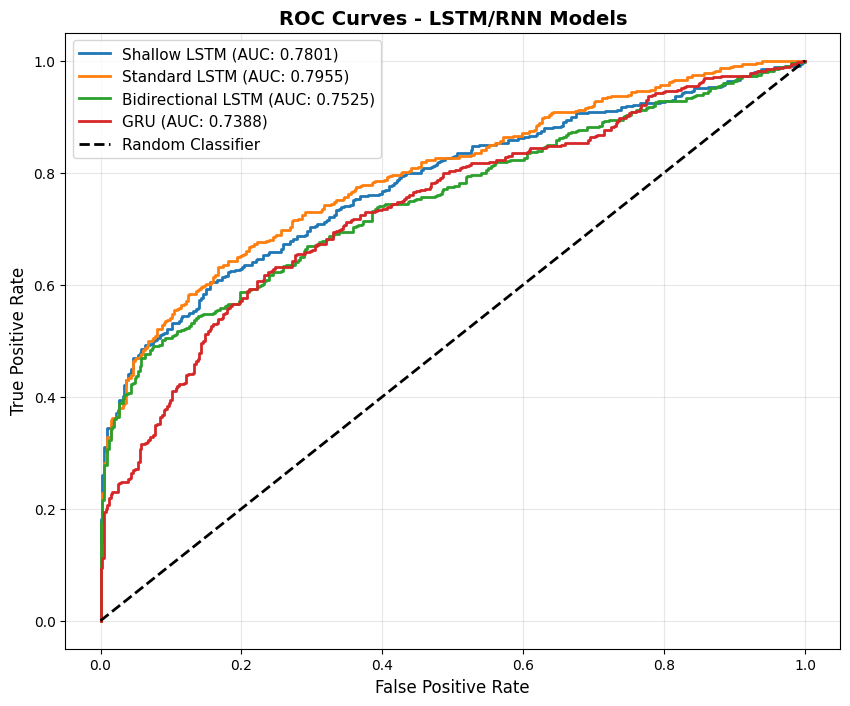

In [17]:
plt.figure(figsize=(10, 8))

for results in results_list:
    fpr, tpr, _ = roc_curve(results['labels'], results['probabilities'])
    plt.plot(fpr, tpr, linewidth=2,
             label=f"{results['model_name']} (AUC: {results['roc_auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - LSTM/RNN Models', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.savefig('../results/visualizations/lstm/roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 16. Model Comparison Bar Charts

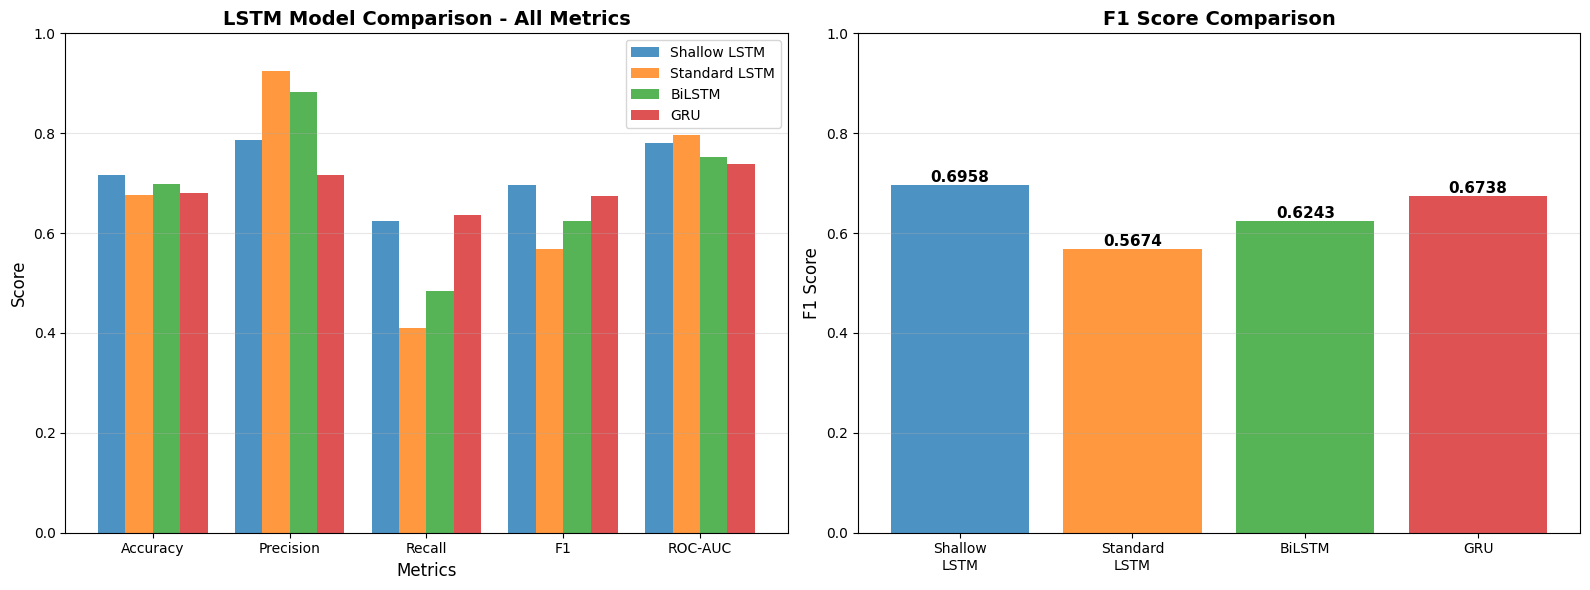

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.2

shallow_scores = [results_shallow['accuracy'], results_shallow['precision'],
                  results_shallow['recall'], results_shallow['f1'], results_shallow['roc_auc']]
standard_scores = [results_standard['accuracy'], results_standard['precision'],
                   results_standard['recall'], results_standard['f1'], results_standard['roc_auc']]
bilstm_scores = [results_bilstm['accuracy'], results_bilstm['precision'],
                 results_bilstm['recall'], results_bilstm['f1'], results_bilstm['roc_auc']]
gru_scores = [results_gru['accuracy'], results_gru['precision'],
              results_gru['recall'], results_gru['f1'], results_gru['roc_auc']]

axes[0].bar(x - 1.5*width, shallow_scores, width, label='Shallow LSTM', alpha=0.8)
axes[0].bar(x - 0.5*width, standard_scores, width, label='Standard LSTM', alpha=0.8)
axes[0].bar(x + 0.5*width, bilstm_scores, width, label='BiLSTM', alpha=0.8)
axes[0].bar(x + 1.5*width, gru_scores, width, label='GRU', alpha=0.8)

axes[0].set_xlabel('Metrics', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('LSTM Model Comparison - All Metrics', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.0])

# F1 Score comparison
models = ['Shallow\nLSTM', 'Standard\nLSTM', 'BiLSTM', 'GRU']
f1_scores = [results_shallow['f1'], results_standard['f1'], results_bilstm['f1'], results_gru['f1']]

bars = axes[1].bar(models, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.8)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].set_title('F1 Score Comparison', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, 1.0])

for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/visualizations/lstm/model_comparison_chart.png', dpi=150, bbox_inches='tight')
plt.show()

## 17. Save Models and Results

In [19]:
import pickle

os.makedirs('../models/saved/lstm_aftershock', exist_ok=True)

torch.save(model_shallow.state_dict(), '../models/saved/lstm_aftershock/shallow_lstm.pt')
torch.save(model_standard.state_dict(), '../models/saved/lstm_aftershock/standard_lstm.pt')
torch.save(model_bilstm.state_dict(), '../models/saved/lstm_aftershock/bilstm.pt')
torch.save(model_gru.state_dict(), '../models/saved/lstm_aftershock/gru.pt')

results_dict = {
    'shallow': results_shallow,
    'standard': results_standard,
    'bilstm': results_bilstm,
    'gru': results_gru,
    'comparison_df': comparison_df
}

with open('../results/visualizations/lstm/test_results.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

print("\n" + "="*70)
print("Models and results saved successfully!")
print("="*70)
print("\nSaved files:")
print("  Models: ../models/saved/lstm_aftershock/")
print("  Results: ../results/visualizations/lstm/test_results.pkl")
print("  Comparison: ../results/visualizations/lstm/model_comparison.csv")


Models and results saved successfully!

Saved files:
  Models: ../models/saved/lstm_aftershock/
  Results: ../results/visualizations/lstm/test_results.pkl
  Comparison: ../results/visualizations/lstm/model_comparison.csv


## 18. Summary and Key Findings

In [20]:
print("\n" + "="*80)
print("LSTM AFTERSHOCK PREDICTION - SUMMARY")
print("="*80)

print(f"\nTASK: Binary classification of aftershock triggering")
print(f"   - Input: Sequences of {SEQ_LENGTH} earthquakes (28 features each)")
print(f"   - Output: No aftershock vs Triggers aftershock (7 days, 50km)")
print(f"   - Training samples: {len(y_train)}")
print(f"   - Test samples: {len(y_test)}")

print("\nBEST MODEL:")
best_idx = comparison_df['F1'].idxmax()
best_model = comparison_df.iloc[best_idx]
print(f"   Model: {best_model['Model']}")
print(f"   F1 Score: {best_model['F1']:.4f}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}")
print(f"   ROC-AUC: {best_model['ROC-AUC']:.4f}")

print("\nMODEL RANKING (by F1 Score):")
ranked = comparison_df.sort_values('F1', ascending=False)
for i, row in ranked.iterrows():
    print(f"   {i+1}. {row['Model']:25s} - F1: {row['F1']:.4f}")

print("\nKEY INSIGHTS:")
print("   - LSTMs capture temporal patterns in earthquake sequences")
print("   - Recurrent connections model time-evolving seismic activity")
print("   - Bidirectional models use both past and future context")
print("   - GRU vs LSTM: simpler architecture, similar performance")

print("\n" + "="*80)
print("Training complete! Check ../results/visualizations/lstm/ for all plots.")
print("="*80)


LSTM AFTERSHOCK PREDICTION - SUMMARY

TASK: Binary classification of aftershock triggering
   - Input: Sequences of 10 earthquakes (28 features each)
   - Output: No aftershock vs Triggers aftershock (7 days, 50km)
   - Training samples: 3998
   - Test samples: 860

BEST MODEL:
   Model: Shallow LSTM
   F1 Score: 0.6958
   Accuracy: 0.7163
   ROC-AUC: 0.7801

MODEL RANKING (by F1 Score):
   1. Shallow LSTM              - F1: 0.6958
   4. GRU                       - F1: 0.6738
   3. Bidirectional LSTM        - F1: 0.6243
   2. Standard LSTM             - F1: 0.5674

KEY INSIGHTS:
   - LSTMs capture temporal patterns in earthquake sequences
   - Recurrent connections model time-evolving seismic activity
   - Bidirectional models use both past and future context
   - GRU vs LSTM: simpler architecture, similar performance

Training complete! Check ../results/visualizations/lstm/ for all plots.
